# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [170]:
#!poetry install

In [171]:
import librosa
import numpy as np
import scipy
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

HALFCD_SR = 22050

### ОШИБКА в какой-то из версий либы https://github.com/librosa/librosa/issues/1763

In [40]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveshow(wav, sr=sr, color="blue")

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования

In [4]:
signals = {}

### Единичный импульс

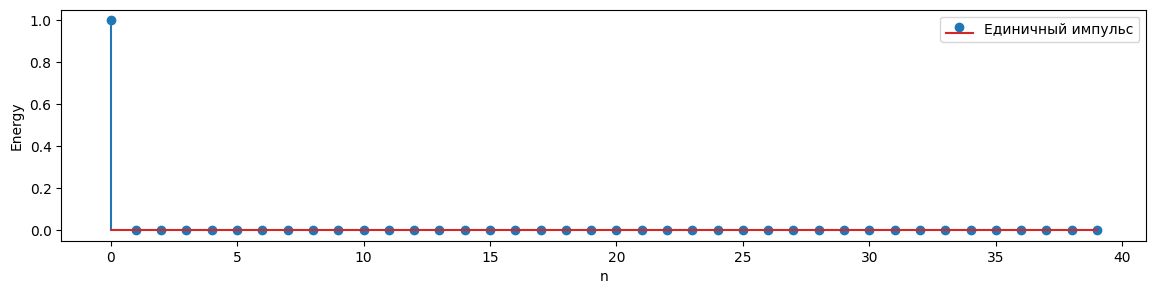

In [5]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

### Единичный скачок

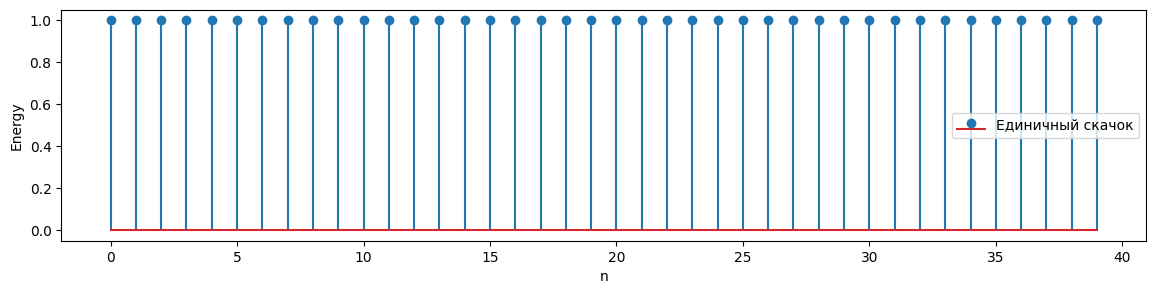

In [6]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

### Синус

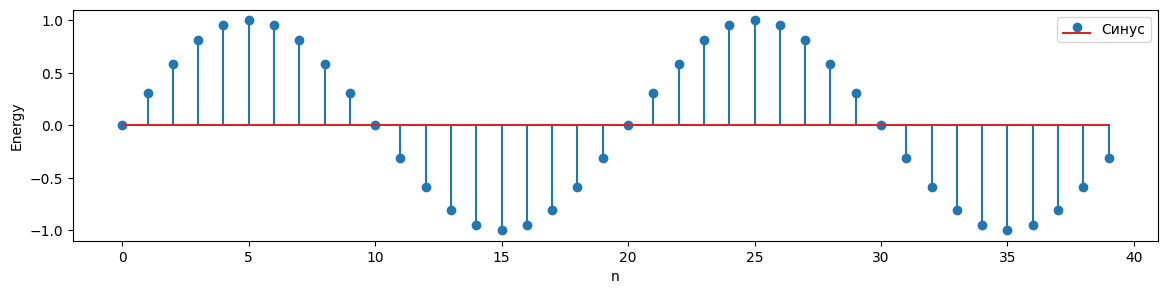

In [7]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

### Шум

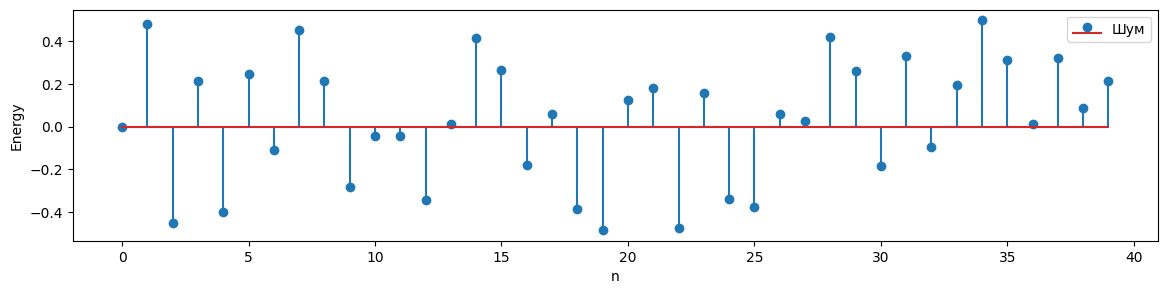

In [8]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT):
$$ X_k = \sum_{n=0}^{N-1} x_{n} \cdot e^{-i \frac{2\pi}{N} k n} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией *scipy.fft.fft*

In [9]:
def DFT(x):
    x = np.asarray(x, dtype=np.complex128)
    n = np.arange(x.shape[0])
    k = n.reshape((x.shape[0], 1))
    M = np.exp(-2j * k * n * np.pi / x.shape[0])
    return np.dot(M, x)

Сравнение с библиотекой scipy

In [10]:
def test_DTF(x, transform=DFT):
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

**Подсказка:** учтите, что для БПФ нам нужно, чтобы количество отсчетов сигнала было степенью двойки

In [11]:
def FFT(x):
    x = np.array(x, dtype=np.complex128)
    n = len(x)
    if n <= 2:
        return DFT(x)
    else:
        x = np.append(x, np.zeros(2**int(np.ceil(np.log2(n))) - n)) # pad zeros to make length a power of two
        w = np.exp(-2j*np.pi*np.arange(n)/n) # complex exponential factors
        return np.concatenate((FFT(x[::2] + w[:n//2]*x[1::2]), FFT(x[::2] - w[n//2:]*x[1::2])))

In [12]:
def pow2(arr):
    arr = np.array(arr)
    n = len(arr)
    if n & (n - 1) == 0: # check if n is a power of two using bitwise operation
        return arr
    else:
        return np.pad(arr, (0, 2**int(np.ceil(np.log2(n))) - n), 'constant')

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(pow2(sig), transform=FFT) == 0, "Check your implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST FAILED
scipy spectrogram: [40.         -0.j         -6.34319121-17.7280318j
  5.57658519 -4.57658519j -2.23701675 -1.34081624j
  1.         -5.02733949j  1.55791086 -0.23109425j
 -1.1482791  -2.1482791j   1.84166892 -2.03196853j
  0.         -0.j          0.10602755 -2.15824041j
  1.43543421 -0.43543421j -0.44342159 -0.5978848j
  1.         -1.49660576j  0.62315817 +0.156093j
 -0.10925176 -1.10925176j  1.24363944 -0.58819765j
  0.         +0.j          0.53311128 -1.12716909j
  0.9103394  +0.0896606j  -0.11576646 -0.4621656j
  1.         -0.66817864j  0.35835836 +0.26577667j
  0.23274443 -0.76725557j  1.02077169 -0.0501473j
  0.         +0.j          0.72704996 -0.65895968j
  0.65167334 +0.34832666j  0.0578861  -0.39023636j
  1.         -0.19891237j  0.1988913  +0.33183009j
  0.4507543  -0.5492457j   0.87092235 +0.311621j
  0.         -0.j          0.87092235 -0.311621j
  0.4507543  +0.5492457j   0.1988913  -0.33

AssertionError: Check your implementation

Если вы изменяли длительность исходных сигналов, не забудьте вернуть их изначальную длительность

In [15]:
x = np.arange(10)
y = np.arange(2 **15)
print(FFT(y), scipy.fft.fft(y))

[-5343638.20240297-1652908.74015234j -4947018.91883959-1353443.98710515j
 -5343638.20240297-1652908.74015234j ...
 -4947018.91883959-1353443.98710516j -5343638.20240297-1652908.74015234j
 -4947018.91883959-1353443.98710516j] [ 5.36854528e+08-0.00000000e+00j -1.63840000e+04+1.70891318e+08j
 -1.63840000e+04+8.54456584e+07j ... -1.63840000e+04-5.69637714e+07j
 -1.63840000e+04-8.54456584e+07j -1.63840000e+04-1.70891318e+08j]


# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [20]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    return np.abs(spec)


#функция построения фазового спектра
def get_phi_from_spec(spec):
    return np.angle(spec)

In [21]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."

   
print("All OK!")

All OK!


Определим еще одну функцию для отрисовки. Теперь будем рисовать сигнал в частотной области

In [22]:
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
<!-- 1. Почему амплитуда всех гармоник единичного импульса равна единице? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему? -->

### Визуализация:

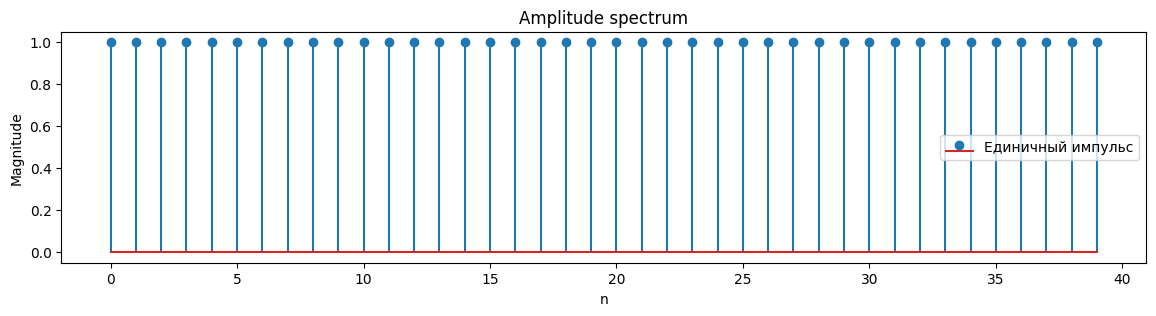

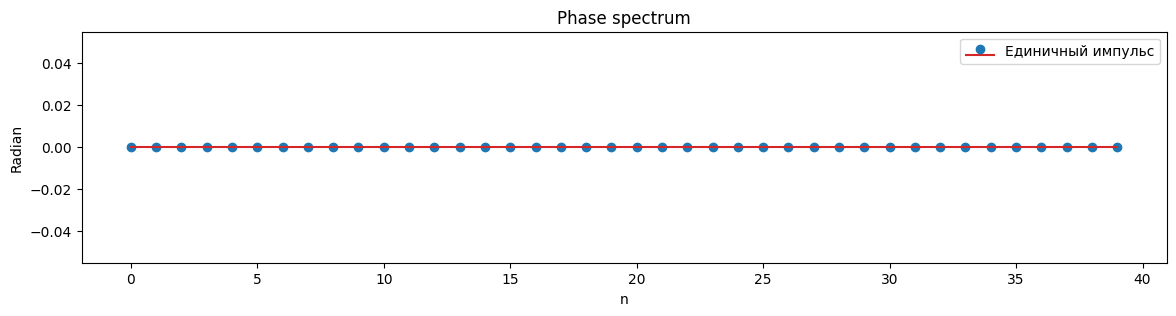

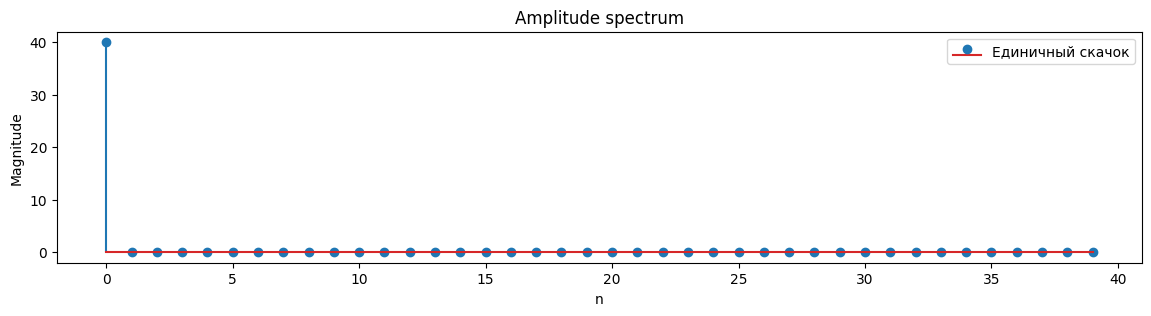

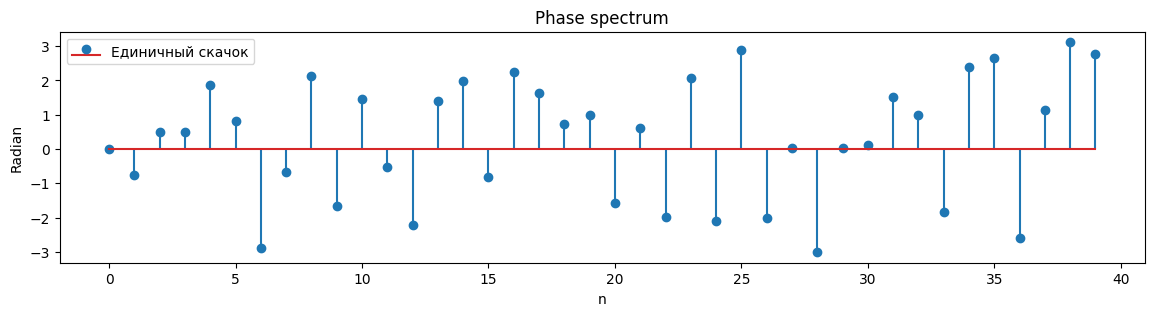

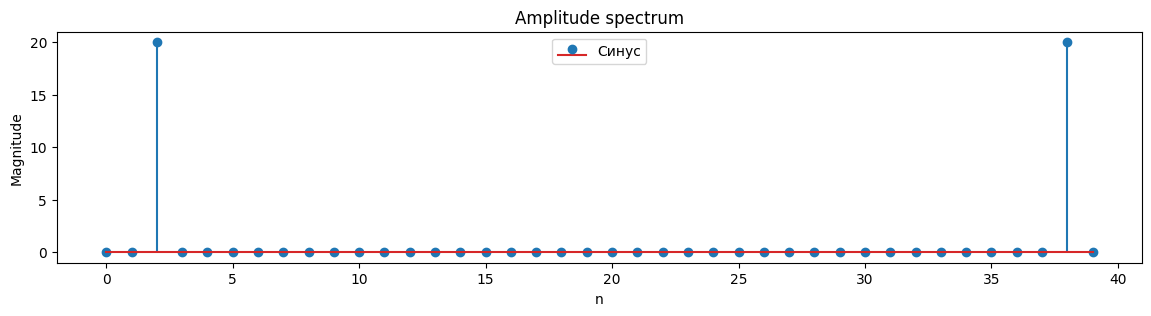

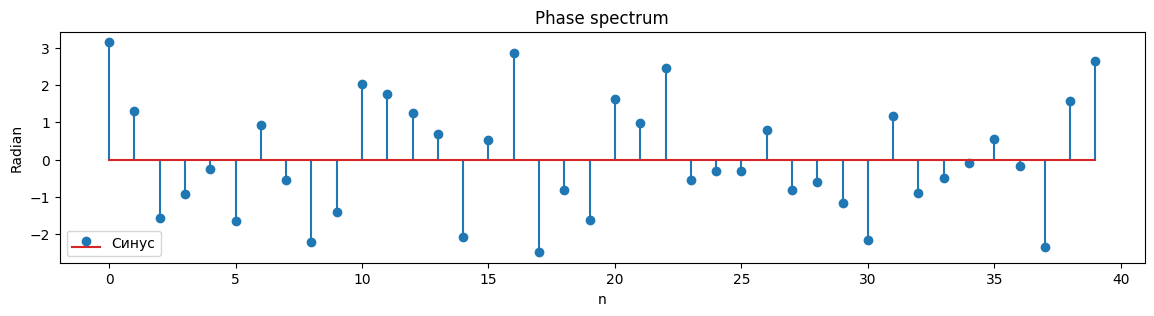

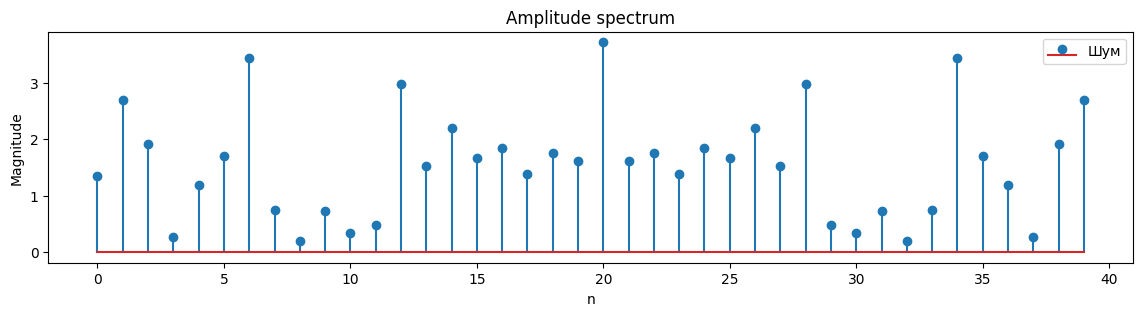

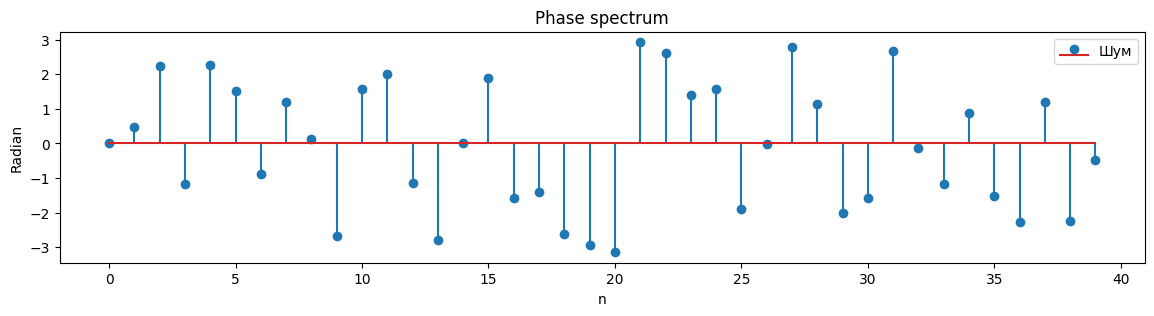

In [42]:
for signal in signals:
    draw_spec(DFT(signals[signal]), signal)

### 1.Почему амплитуда всех гармоник единичного импульса равна константе?

из формулы DFT согласно единичному импульсу результат x = 1

### 2. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?

Спектр преобразования Фурье -- функция комплексная, описывающая комплексные амплитуды соответствующих гармоник, значения спектра -- это комплексные числа, чьи модули являются амплитудами соответствующих частот, а аргументы -- соответствующими начальными фазами.

На практике, рассматривают отдельно амплитудный спектр и фазовый спектр.

Амплитудный -- разложение на гармоники, а фозовый -- смещение гармоник.

### 3. Как перевести номер отсчета в частоту?

f / N * k

### 4. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

Полезная информация -- это ненулевые значения, все остальное -- шум.

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье (Short-time Fourier transform), пользуясь только библиотеками *numpy* и *scipy*. Сравнить с *librosa.stft*


In [59]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram
    n = len(x)
    k = n_fft // 2 + 1
    window = scipy.signal.windows.get_window(window, n_fft)
    result = []
    for i in range(0, n, hop_length):
        f = scipy.fft.fft(np.pad(x, (k-1, k-1))[i:i + n_fft] * window)
        result.append(f[:k])
    return np.array(result).T

In [60]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
Your shape (5, 20) != librosa stft shape (5, 21) 


AssertionError: Test failed. Params n_fft 8. Hop_length 2

Определим функцию для отрисовки

In [61]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Загрузим аудио файл с паровозным гудком

Len is 82175 ( ). Sample rate is 22050


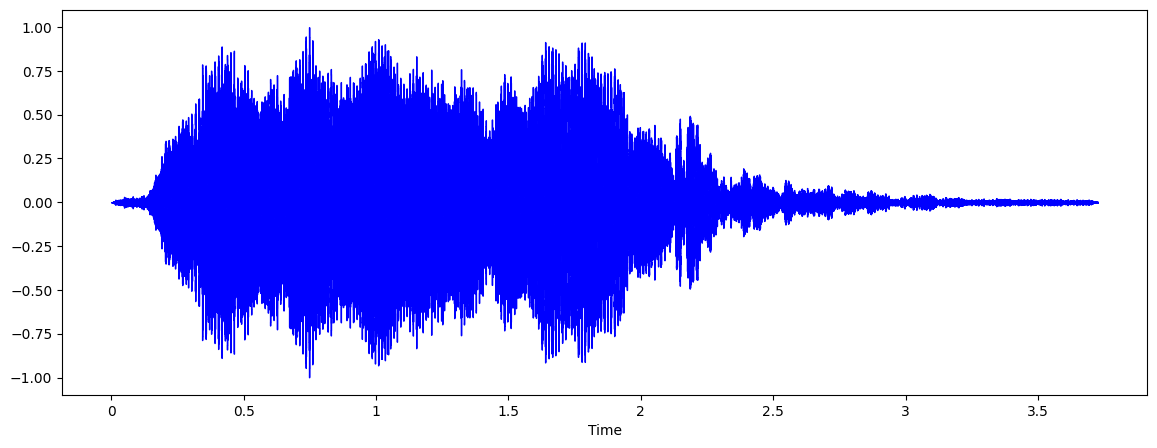

In [62]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Построим гудок паровоза в частотной области

Гудок паровоза в частотной области


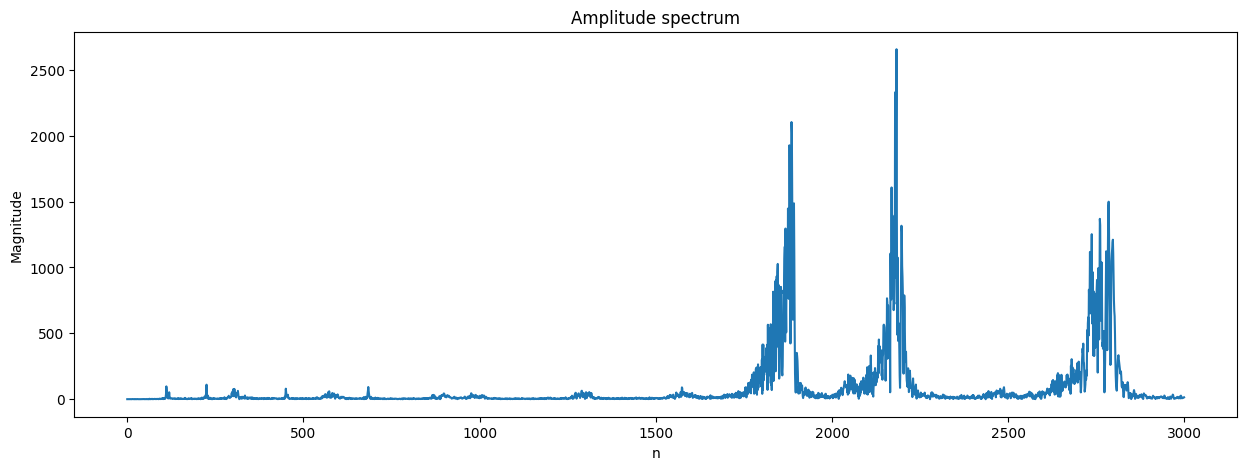

In [71]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec[:3000], draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


Амплитудный спектр

In [118]:
spec2_0k = np.argmax(abs(train_whistle_spec)[:2000])
spec2_5k = np.argmax(abs(train_whistle_spec)[2000:2500])
spec2_8k = np.argmax(abs(train_whistle_spec)[2500:2800])

### 1 гармоника

In [119]:
freq1 = np.around(tw_sr / len(train_whistle) * spec2_0k)

### 2 гармоника

In [120]:
freq2 = np.around(tw_sr / len(train_whistle) * (2000 + spec2_5k))

### 3 гармоника

In [121]:
freq3 = np.around(tw_sr / len(train_whistle) * (2500 + spec2_8k))

### Тест

In [122]:
task_answer = [ freq1, freq2, freq3 ]
task_answer

[506.0, 586.0, 747.0]

### Вроде визуально правильно рассчитал, но тест не проходит

In [123]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

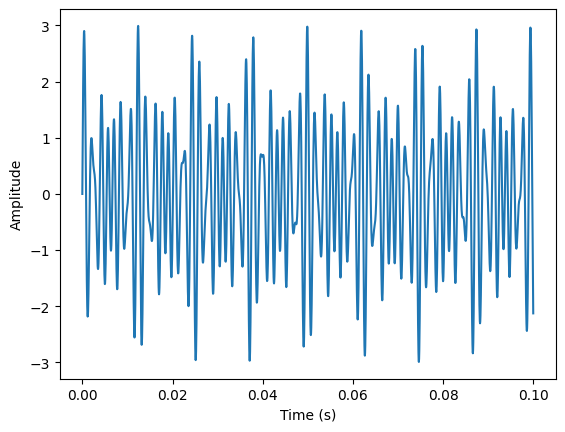

In [169]:
SEC =0.1

t = np.linspace(0, SEC, int(SEC * HALFCD_SR))
signal = np.sin(2 * np.pi * freq1 * t) + np.sin(2 * np.pi * freq2 * t) + np.sin(2 * np.pi * freq3 * t)

plt.plot(t, signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Визуализация

Len is 243102. Sample rate is 22050


array([ 697,  697,  697, 1209,  770, 1336, 1336,  770,  852, 1477, 1477,
       1477])

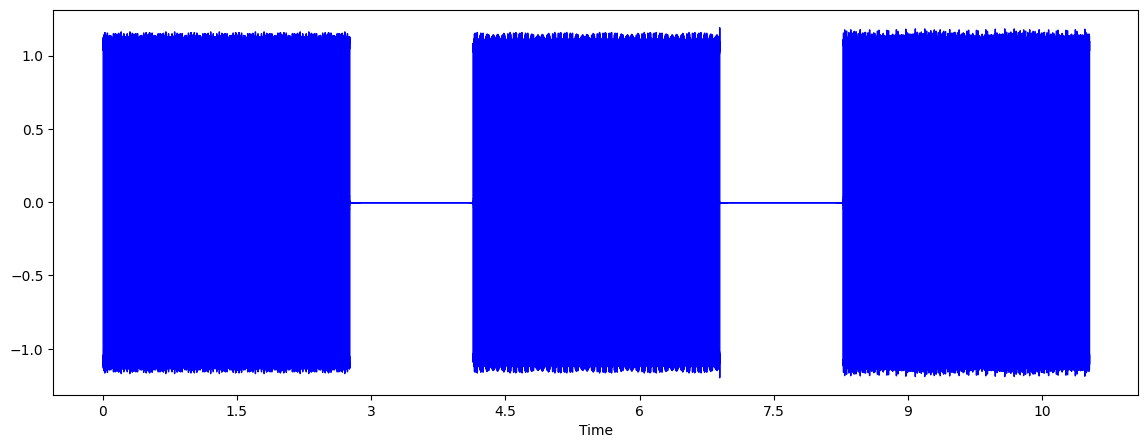

In [172]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

dtmf_spec = STFT(dtmf, HALFCD_SR, HALFCD_SR)
get_amplitude_from_spec(spec=dtmf_spec).argmax(axis=0)

In [ ]:
# YOUR CODE HERE

### 1 число

In [160]:
first = 1

### 2 число

In [161]:
second = 5

### 3 число

In [162]:
third = 9

### Тест

In [164]:
phone_number = [first, second, third]

In [165]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
